# 2024 U.S. Election Sentiment on X

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from transformers import AutoTokenizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

import torch 
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, pipeline

# Functions

In [2]:
def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def check_nulls_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_word_tokens = [w.lower().strip() for w in filtered_tokens if w.lower() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_word_tokens).strip()

def lemmatize_words(content):
  
  lemma = WordNetLemmatizer()
  
  stop_free = " ".join([ word for word in content.lower().split() if word not in ENGLISH_STOP_WORDS])
  punc_free = "".join(re.sub(r"[^a-zA-Z\s]", "", stop_free))
  lemmatize_words = " ".join([lemma.lemmatize(word) for word in punc_free.split()])
  return lemmatize_words

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

# EDA Analysis

In [4]:
train, test, val = None, None, None
paths = ["train", "val", "test"]

for path in paths:
  if path == "train":
    train = pd.read_csv(f"/Users/maukanmir/Downloads/archive/{path}.csv")
  elif path == "val":
    val= pd.read_csv(f"/Users/maukanmir/Downloads/archive/{path}.csv")
  else:
    test= pd.read_csv(f"/Users/maukanmir/Downloads/archive/{path}.csv")

In [5]:
train.shape

(500, 9)

In [6]:
test.shape

(50, 9)

In [7]:
val.shape

(50, 9)

In [8]:
train

,tweet_id,user_handle,timestamp,tweet_text,candidate,party,retweets,likes,sentiment
0,1,@user123,2024-11-03 08:45:00,Excited to see Kamala Harris leading the Democ...,Kamala Harris,Democratic Party,120,450,positive
1,2,@politicsFan,2024-11-03 09:15:23,Donald Trump's policies are the best for our e...,Donald Trump,Republican Party,85,300,positive
2,3,@greenAdvocate,2024-11-03 10:05:45,Jill Stein's environmental plans are exactly w...,Jill Stein,Green Party,60,200,positive
3,4,@indieVoice,2024-11-03 11:20:10,Robert Kennedy offers a fresh perspective outs...,Robert Kennedy,Independent,40,150,neutral
4,5,@libertyLover,2024-11-03 12:35:55,Chase Oliver's libertarian stance promotes tru...,Chase Oliver,Libertarian Party,30,120,positive
...,...,...,...,...,...,...,...,...,...
495,496,@user1067,2024-02-10 08:50:30,Kamala Harris is a symbol of progressive leade...,Kamala Harris,Democratic Party,95,360,positive
496,497,@econTalk7,2024-02-10 09:15:55,Trump's economic strategies are showing mixed ...,Donald Trump,Republican Party,100,440,neutral
497,498,@greenFutureNow7,2024-02-10 10:05:30,Jill Stein's solar projects are leading the wa...,Jill Stein,Green Party,75,240,positive
498,499,@indiePerspective7,2024-02-10 11:35:25,Robert Kennedy offers pragmatic solutions outs...,Robert Kennedy,Independent,18,85,neutral


In [9]:
train.describe()

,tweet_id,retweets,likes
count,500.000000,500.000000,500.000000
mean,250.500000,64.236000,248.920000
std,144.481833,27.715349,120.562034
min,1.000000,18.000000,85.000000
25%,125.750000,40.000000,150.000000
50%,250.500000,70.000000,225.000000
75%,375.250000,90.000000,340.000000
max,500.000000,120.000000,500.000000


In [11]:
check_nulls_dupes(train)
check_nulls_dupes(val)
check_nulls_dupes(test)

The Amount of Nulls: tweet_id       0
user_handle    0
timestamp      0
tweet_text     0
candidate      0
party          0
retweets       0
likes          0
sentiment      0
dtype: int64
The Amount of Dupes: 0
The Amount of Nulls: tweet_id       0
user_handle    0
timestamp      0
tweet_text     0
candidate      0
party          0
retweets       0
likes          0
sentiment      0
dtype: int64
The Amount of Dupes: 0
The Amount of Nulls: tweet_id       0
user_handle    0
timestamp      0
tweet_text     0
candidate      0
party          0
retweets       0
likes          0
sentiment      0
dtype: int64
The Amount of Dupes: 0


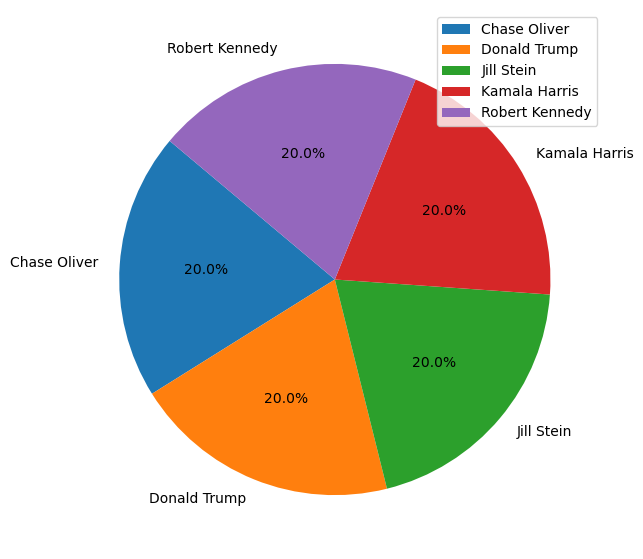

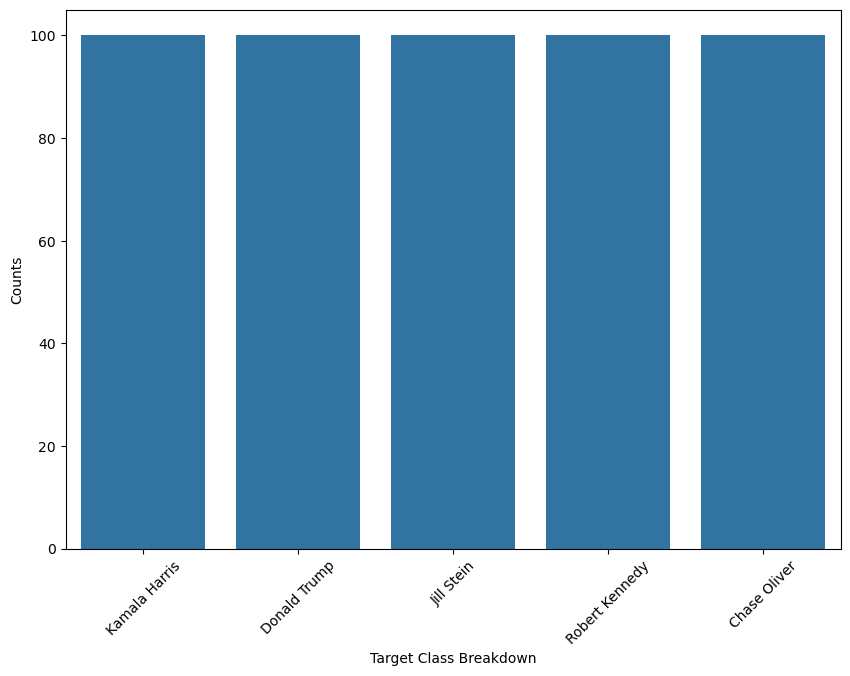

In [12]:
check_class_imbalance(train["candidate"])

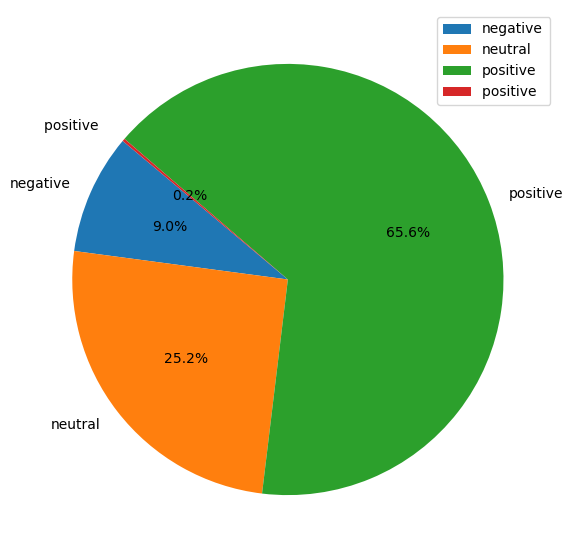

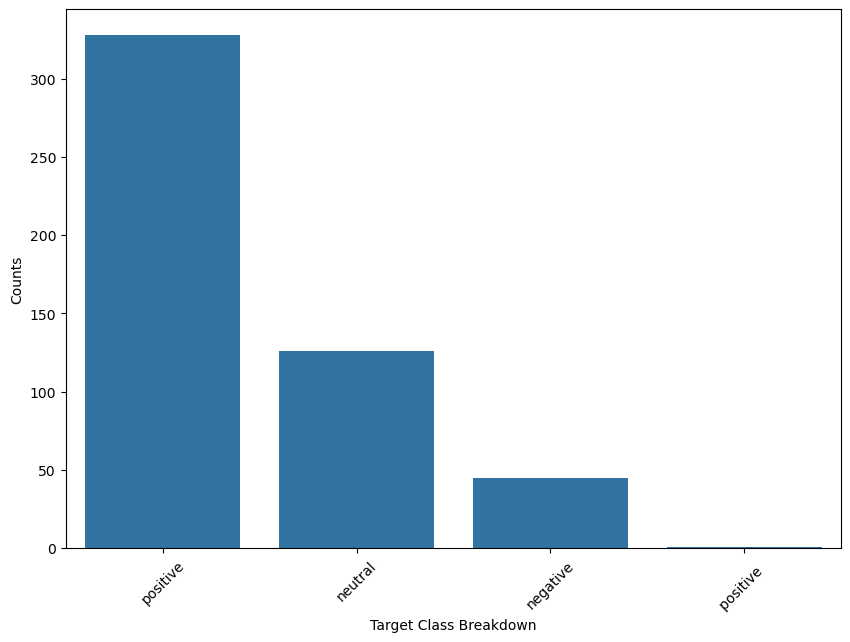

In [13]:
check_class_imbalance(train["sentiment"])

In [14]:
train["sentiment"].unique()

array(['positive', 'neutral', 'negative', 'positive  '], dtype=object)

In [15]:
test["sentiment"].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [16]:
val["sentiment"].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [18]:
train[train["sentiment"] == 'positive  ']

,tweet_id,user_handle,timestamp,tweet_text,candidate,party,retweets,likes,sentiment
99,100,@libertyValues,2024-11-22 12:30:20,Chase Oliver's commitment to liberty resonates...,Chase Oliver,Libertarian Party,50,175,positive


In [19]:
train.dtypes

tweet_id        int64
user_handle    object
timestamp      object
tweet_text     object
candidate      object
party          object
retweets        int64
likes           int64
sentiment      object
dtype: object

In [20]:
train['sentiment'] = train['sentiment'].str.strip()

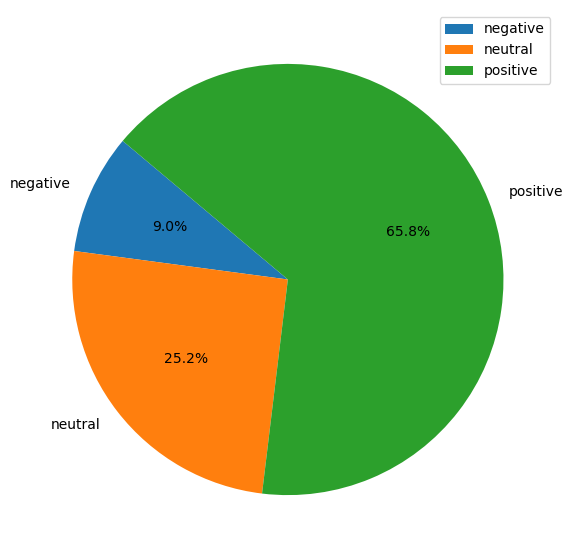

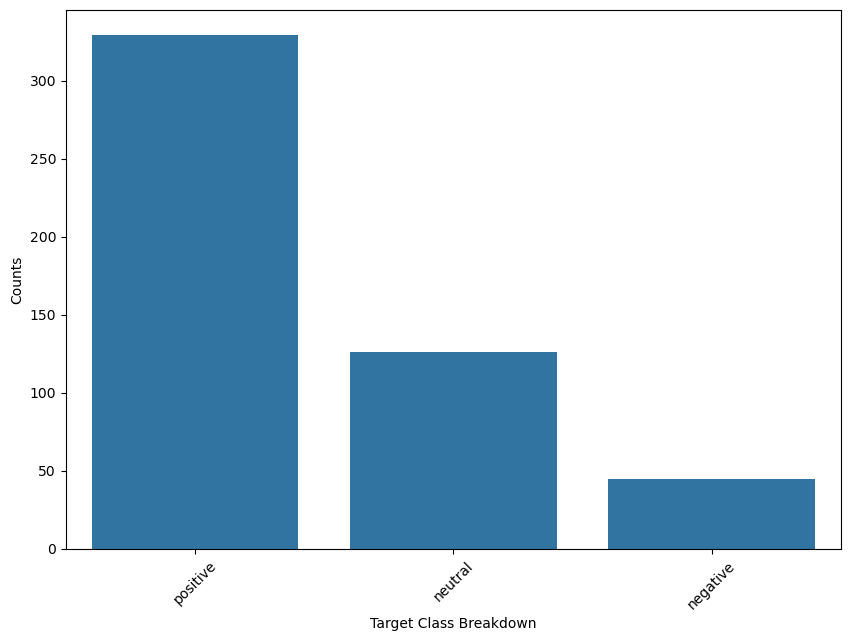

In [21]:
check_class_imbalance(train["sentiment"])

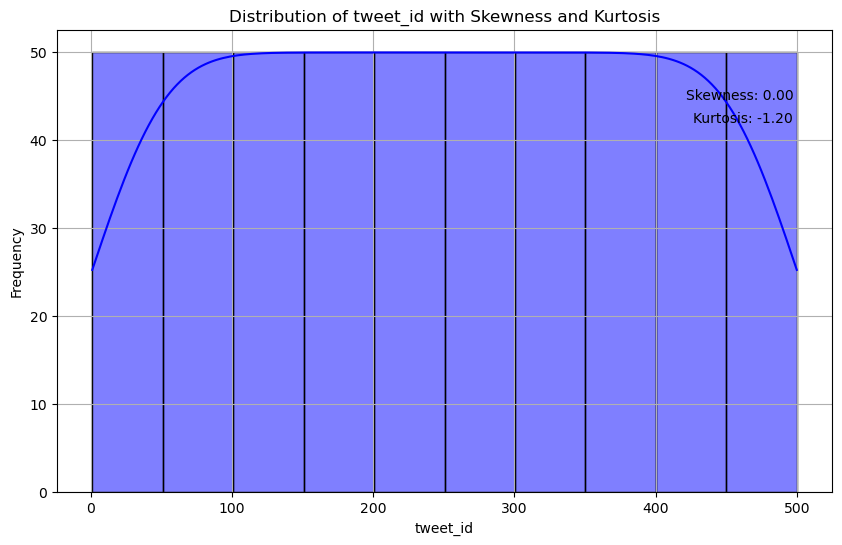

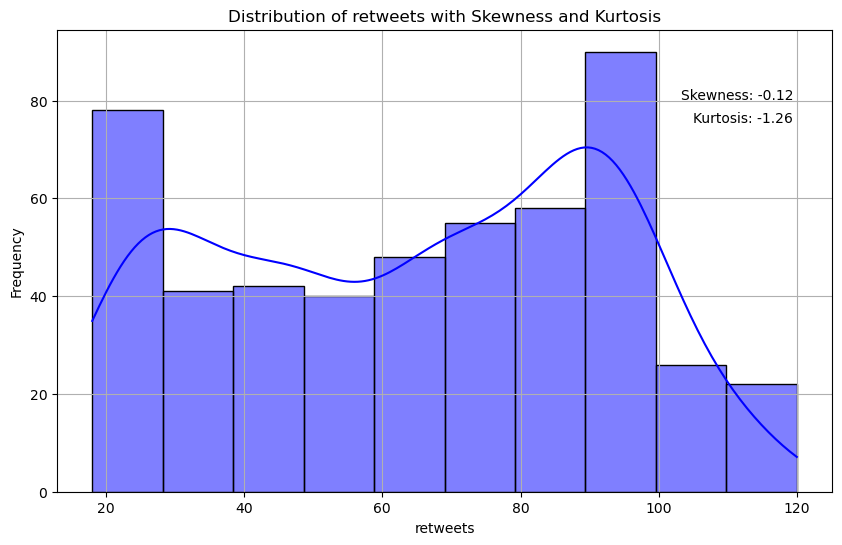

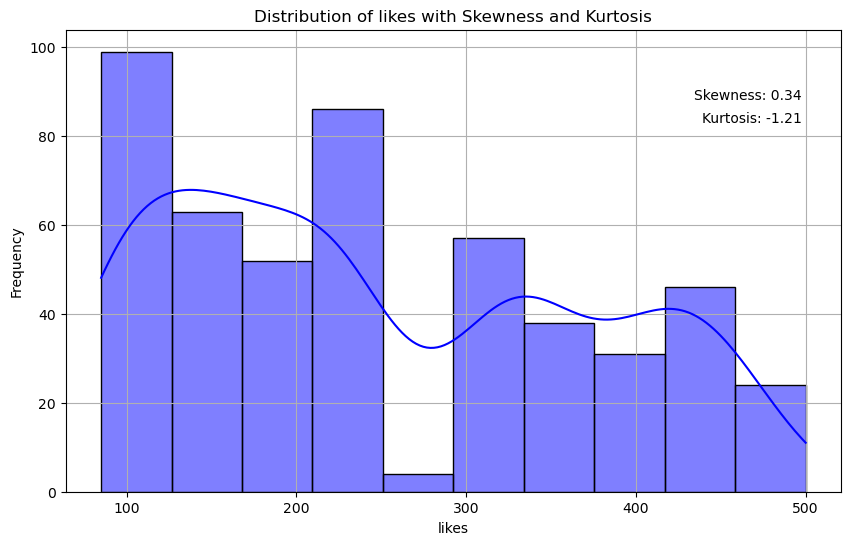

In [23]:
int_columns = train.select_dtypes(exclude="object")
dist_plot(int_columns)

# Popular Candidates

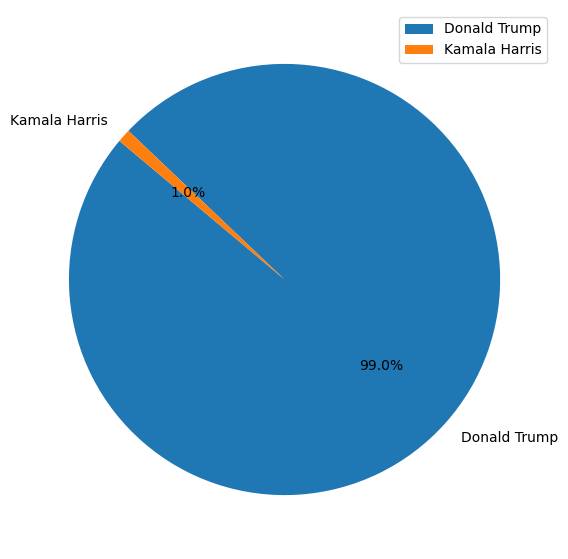

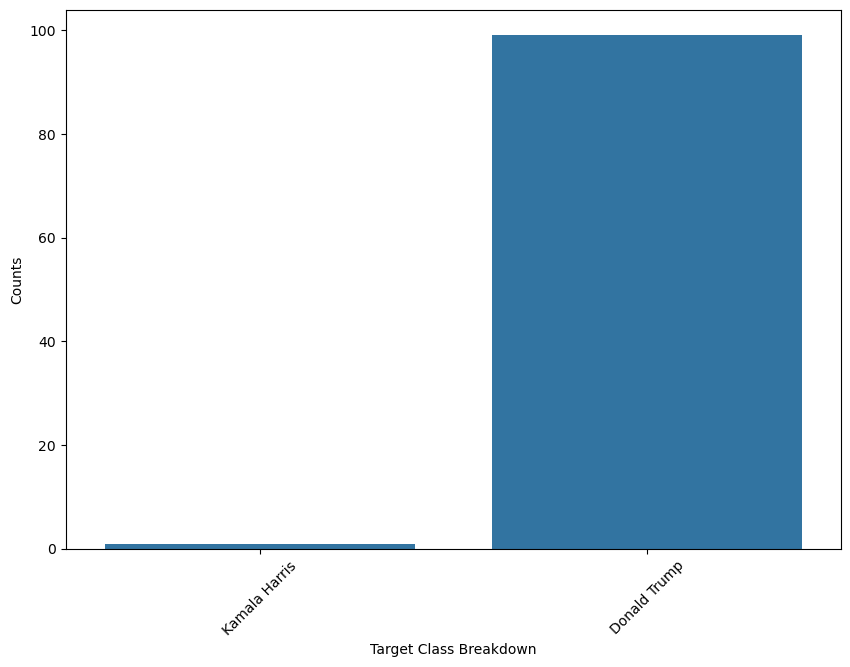

In [26]:
highly_popular_likes = train[train["likes"] >=400]
check_class_imbalance(highly_popular_likes["candidate"])

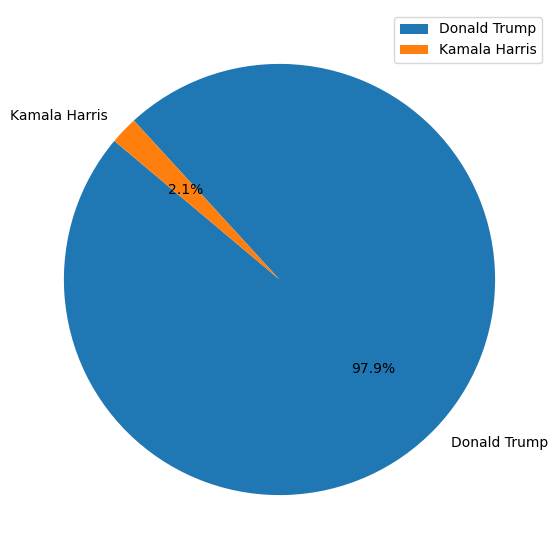

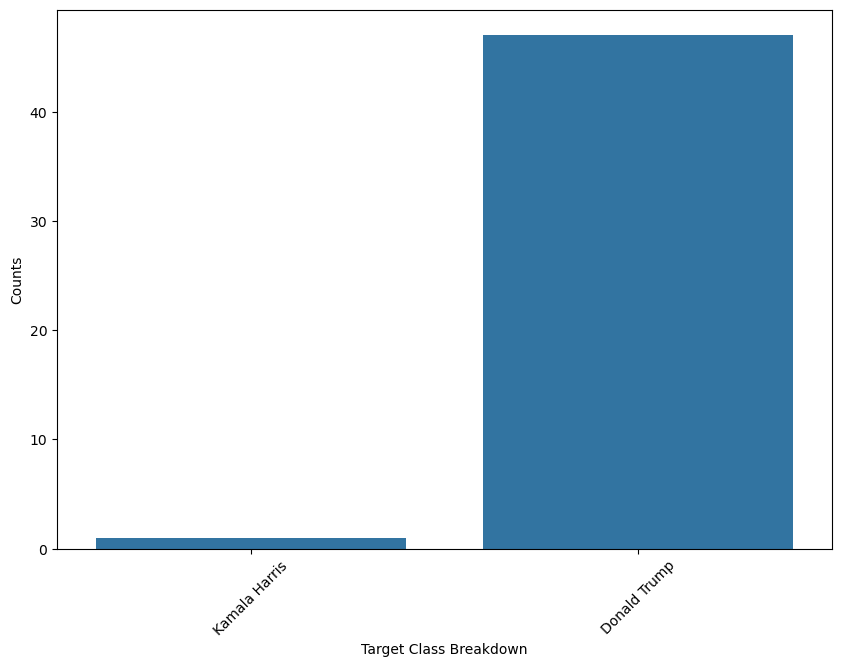

In [27]:
highly_popular_retweet = train[train["retweets"] >=100]
check_class_imbalance(highly_popular_retweet["candidate"])

In [29]:
train["shorten_tweets"] = train["tweet_text"].apply(lambda x: x if len(x) <=512 else x[:512])

In [32]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

train["sentiment_BERT"] = train["shorten_tweets"].apply(lambda x: sentiment_pipeline(x)[0]["label"])
train["score"] = train["shorten_tweets"].apply(lambda x: sentiment_pipeline(x)[0]["score"])
train["sentiment_score"] = train["sentiment_BERT"].apply(lambda x: int(x.split(" ")[0]))

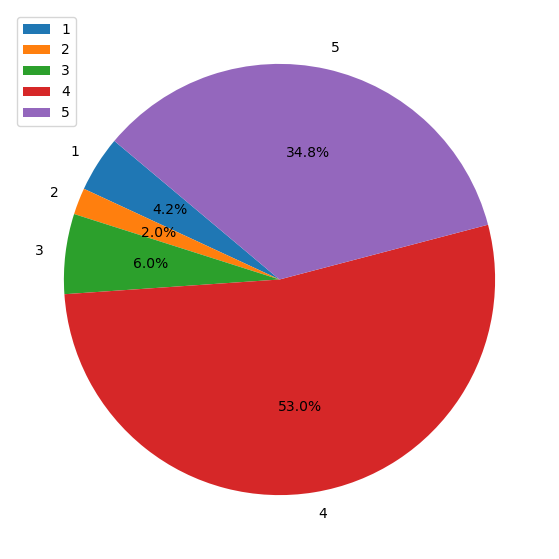

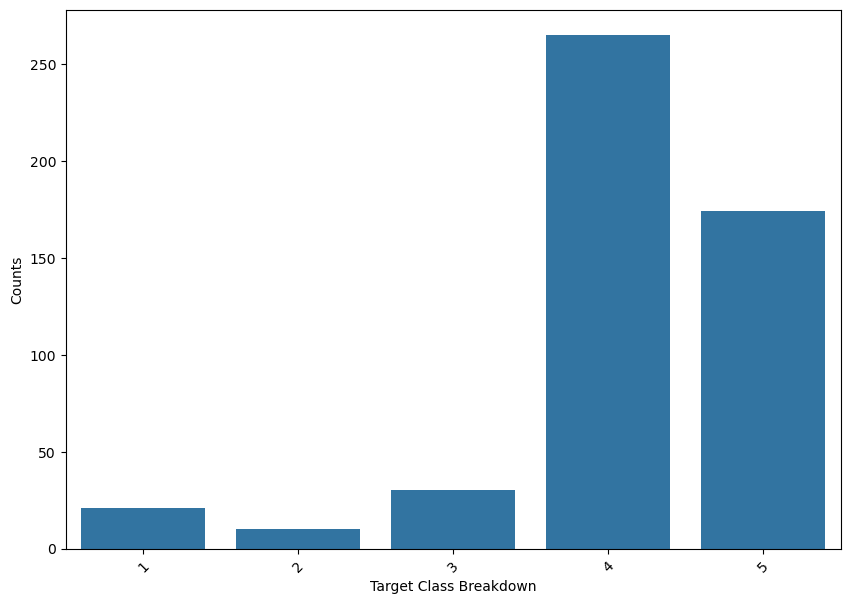

In [34]:
check_class_imbalance(train["sentiment_score"])

In [ ]:
check_class_imbalance(train["sentiment_score"])